## Comparing flight prices based on booking date

### Data cleaning

In [98]:
!pip install seaborn

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

### Load the dataset

In [100]:
# Step 1: Load the datasets
weekBefore = pd.read_csv('Flights_WeekBefore.csv')
dayBefore = pd.read_csv('FlightsDayBefore.csv')

In [101]:
# Check for missing values
missing_values = weekBefore.isnull().sum()
missing_values2 = dayBefore.isnull().sum()

print(missing_values)
print(missing_values2)

company_name       0
flight_duration    0
price              0
departure_date     0
departure_time     0
arrival_time       0
stops              0
departure_city     0
arrival_city       0
dtype: int64
company_name       0
flight_duration    0
price              0
departure_date     0
departure_time     0
arrival_time       0
stops              0
departure_city     0
arrival_city       0
dtype: int64


In [102]:
# Cleaning the 'price' column: remove 'SAR' and commas, convert to float
weekBefore['price'] = weekBefore['price'].replace({'SAR ': '', ',': ''}, regex=True).astype(float)
dayBefore['price'] = dayBefore['price'].replace({'SAR ': '', ',': ''}, regex=True).astype(float)

In [103]:
# Check for missing prices
missing_prices = weekBefore['price'].isnull().sum()
missing_prices2 = dayBefore['price'].isnull().sum()

print("Number of missing prices:", missing_prices)
print("Number of missing prices:", missing_prices2)

Number of missing prices: 0
Number of missing prices: 0


In [104]:
# Clean the 'departure_time' and 'arrival_time' columns to remove weird symbols
weekBefore['departure_time'] = weekBefore['departure_time'].str.replace(r'[\u200B-\u200D\u202F\u00A0]', '', regex=True)
weekBefore['arrival_time'] = weekBefore['arrival_time'].str.replace(r'[\u200B-\u200D\u202F\u00A0]', '', regex=True)

dayBefore['departure_time'] = dayBefore['departure_time'].str.replace(r'[\u200B-\u200D\u202F\u00A0]', '', regex=True)
dayBefore['arrival_time'] = dayBefore['arrival_time'].str.replace(r'[\u200B-\u200D\u202F\u00A0]', '', regex=True)

In [105]:
# Ensure all values are treated as strings, then use regex to replace ' stop' or ' stops' with an empty string
weekBefore['stops'] = weekBefore['stops'].astype(str).str.replace(r'\s*stops?', '', regex=True).str.strip()
dayBefore['stops'] = dayBefore['stops'].astype(str).str.replace(r'\s*stops?', '', regex=True).str.strip()

# Convert the cleaned 'stops' column to numeric
weekBefore['stops'] = pd.to_numeric(weekBefore['stops'], errors='coerce')
dayBefore['stops'] = pd.to_numeric(dayBefore['stops'], errors='coerce')

# Convert the numeric column to integers (if not NaN)
weekBefore['stops'] = weekBefore['stops'].fillna(0).astype(int)  # Replace NaN with 0 and convert to int
dayBefore['stops'] = dayBefore['stops'].fillna(0).astype(int)  # Replace NaN with 0 and convert to int

In [106]:
# Count the number of duplicate rows
num_duplicates = weekBefore.duplicated().sum()
num_duplicates2 = dayBefore.duplicated().sum()

# Print the number of duplicates
print("Number of duplicate rows in dataset of the flight a week ahead:", num_duplicates)
print("Number of duplicate rows a day before the flight:", num_duplicates2)

Number of duplicate rows in dataset of the flight a week ahead: 48
Number of duplicate rows a day before the flight: 491


In [107]:
# Dropping duplicates (if any)
weekBefore = weekBefore.drop_duplicates(keep='first')
dayBefore = dayBefore.drop_duplicates(keep='first')

In [108]:
# Count the number of duplicate rows in the cleaned dataset
num_duplicates_cleaned = weekBefore.duplicated().sum()
num_duplicates_cleaned2 = dayBefore.duplicated().sum()

# Print the number of duplicates in the cleaned dataset
print("Number of duplicate rows in the cleaned data:", num_duplicates_cleaned)
print("Number of duplicate rows in the cleaned data:", num_duplicates_cleaned2)

Number of duplicate rows in the cleaned data: 0
Number of duplicate rows in the cleaned data: 0


In [109]:
def convert_duration_to_minutes(duration_str):
    # Check if the input is not a string
    if not isinstance(duration_str, str):
        return np.nan  # Return NaN for non-string inputs
    
    if pd.isnull(duration_str) or duration_str.strip() == "":
        return np.nan  # Return NaN for null or empty strings
    
    # Using a more flexible regex pattern
    match = re.match(r'(?:(\d+)\s*hour(?:s)?|(\d+)\s*hr(?:s)?)?\s*(?:(\d+)\s*minute(?:s)?|(\d+)\s*min(?:s)?)?', duration_str.strip(), re.IGNORECASE)
    
    if match is None:
        print(f"Unmatched duration string: '{duration_str}'")  # Debugging output
        return np.nan  # If format is unexpected, return NaN

    
    # Handle the cases where only hours are present
    hours = int(match.group(1)) * 60 if match.group(1) else (int(match.group(2)) * 60 if match.group(2) else 0)
    
    # Handle minutes: if minutes are present, get them; otherwise, set to 0
    minutes = int(match.group(3)) if match.group(3) else (int(match.group(4)) if match.group(4) else 0)
    
    return hours + minutes  # Total minutes

# Example of converting the 'flight_duration' column
weekBefore['flight_duration'] = weekBefore['flight_duration'].apply(convert_duration_to_minutes)
dayBefore['flight_duration'] = dayBefore['flight_duration'].apply(convert_duration_to_minutes)

print(weekBefore.head())
print(dayBefore.head())


  company_name  flight_duration  price departure_date departure_time  \
0     Flyadeal              100  319.0     2024-10-17        10:15PM   
1     Flyadeal              105  359.0     2024-10-17         4:10PM   
2     Flyadeal               95  359.0     2024-10-17         4:35PM   
3     Flyadeal              100  359.0     2024-10-17         5:20PM   
4       Flynas              110  389.0     2024-10-17         3:40PM   

  arrival_time  stops departure_city arrival_city  
0      11:55PM      0            JED          RUH  
1       5:55PM      0            JED          RUH  
2       6:10PM      0            JED          RUH  
3       7:00PM      0            JED          RUH  
4       5:30PM      0            JED          RUH  
  company_name  flight_duration  price departure_date departure_time  \
0     Flyadeal               95  219.0     2024-10-24         6:10AM   
1       Flynas              110  259.0     2024-10-24        10:35AM   
2       Saudia              110  359.0 

## Prepare the Data to be compared

### Changing the names of the coulmns to match the secondrey data

In [ ]:
# Renaming the columns
weekBefore.rename(columns={
    'company_name': 'Airline',
    'flight_duration': 'Flight Duration',
    'price': 'Price',
    'departure_date': 'Departure Date',
    'departure_time': 'Departure Time',
    'arrival_time': 'Arrival Time',
    'stops': 'Number Of Stops',
    'departure_city': 'Departure City',
    'arrival_city': 'Arrival City'
}, inplace=True)

# Display the first few rows to confirm the changes
print(weekBefore.head())

    Airline  Flight Duration  Price Departure Date Departure Time  \
0  Flyadeal              100  319.0     2024-10-17        10:15PM   
1  Flyadeal              105  359.0     2024-10-17         4:10PM   
2  Flyadeal               95  359.0     2024-10-17         4:35PM   
3  Flyadeal              100  359.0     2024-10-17         5:20PM   
4    Flynas              110  389.0     2024-10-17         3:40PM   

  Arrival Time  Number Of Stops Departure City Arrival City  
0      11:55PM                0            JED          RUH  
1       5:55PM                0            JED          RUH  
2       6:10PM                0            JED          RUH  
3       7:00PM                0            JED          RUH  
4       5:30PM                0            JED          RUH  


In [ ]:
# Renaming the columns
dayBefore.rename(columns={
    'company_name': 'Airline',
    'flight_duration': 'Flight Duration',
    'price': 'Price',
    'departure_date': 'Departure Date',
    'departure_time': 'Departure Time',
    'arrival_time': 'Arrival Time',
    'stops': 'Number Of Stops',
    'departure_city': 'Departure City',
    'arrival_city': 'Arrival City'
}, inplace=True)

# Display the first few rows to confirm the changes
print(dayBefore.head())

    Airline  Flight Duration  Price Departure Date Departure Time  \
0  Flyadeal               95  219.0     2024-10-24         6:10AM   
1    Flynas              110  259.0     2024-10-24        10:35AM   
2    Saudia              110  359.0     2024-10-24         8:00AM   
3  Flyadeal              100  219.0     2024-10-24        12:15AM   
4  Flyadeal               95  219.0     2024-10-24         1:45AM   

  Arrival Time  Number Of Stops Departure City Arrival City  
0       7:45AM                0            JED          RUH  
1      12:25PM                0            JED          RUH  
2       9:50AM                0            JED          RUH  
3       1:55AM                0            JED          RUH  
4       3:20AM                0            JED          RUH  


### Changing "Arrival Time", and "Departure Time" data type format to 24 hour

In [112]:
# Removing the '+1', '+2', etc., from the 'Arrival Time' column
weekBefore['Arrival Time'] = weekBefore['Arrival Time'].apply(lambda x: re.sub(r'\+\d+', '', x))


# Convert 'Departure Time' and 'Arrival Time' to 24-hour format
weekBefore['Departure Time'] = pd.to_datetime(weekBefore['Departure Time'], format='%I:%M%p', errors='coerce').dt.time
weekBefore['Arrival Time'] = pd.to_datetime(weekBefore['Arrival Time'], format='%I:%M%p', errors='coerce').dt.time

# Checking the first few rows to verify the changes
weekBefore[['Departure Time', 'Arrival Time']].head()

,Departure Time,Arrival Time
0,22:15:00,23:55:00
1,16:10:00,17:55:00
2,16:35:00,18:10:00
3,17:20:00,19:00:00
4,15:40:00,17:30:00


In [113]:
# Removing the '+1', '+2', etc., from the 'Arrival Time' column
dayBefore['Arrival Time'] = dayBefore['Arrival Time'].apply(lambda x: re.sub(r'\+\d+', '', x))


# Convert 'Departure Time' and 'Arrival Time' to 24-hour format
dayBefore['Departure Time'] = pd.to_datetime(dayBefore['Departure Time'], format='%I:%M%p', errors='coerce').dt.time
dayBefore['Arrival Time'] = pd.to_datetime(dayBefore['Arrival Time'], format='%I:%M%p', errors='coerce').dt.time

# Checking the first few rows to verify the changes
dayBefore[['Departure Time', 'Arrival Time']].head()

,Departure Time,Arrival Time
0,06:10:00,07:45:00
1,10:35:00,12:25:00
2,08:00:00,09:50:00
3,00:15:00,01:55:00
4,01:45:00,03:20:00


### Adding a new column "Flight Lands Next Day"

In [114]:
# Adding a new column 'Flight Lands Next Day' with binary values based on the condition
weekBefore['Flight Lands Next Day'] = weekBefore.apply(
    lambda row: 1 if row['Arrival Time'] and row['Departure Time'] and row['Arrival Time'].hour < row['Departure Time'].hour else 0,
    axis=1
)

# Checking the updated dataset with the new column
weekBefore[['Departure Time', 'Arrival Time', 'Flight Lands Next Day']].head()

,Departure Time,Arrival Time,Flight Lands Next Day
0,22:15:00,23:55:00,0
1,16:10:00,17:55:00,0
2,16:35:00,18:10:00,0
3,17:20:00,19:00:00,0
4,15:40:00,17:30:00,0


In [ ]:
dayBefore['Flight Lands Next Day'] = dayBefore.apply(
    lambda row: 1 if row['Arrival Time'] and row['Departure Time'] and row['Arrival Time'].hour < row['Departure Time'].hour else 0,
    axis=1
)
dayBefore[['Departure Time', 'Arrival Time', 'Flight Lands Next Day']].head()

,Departure Time,Arrival Time,Flight Lands Next Day
0,06:10:00,07:45:00,0
1,10:35:00,12:25:00,0
2,08:00:00,09:50:00,0
3,00:15:00,01:55:00,0
4,01:45:00,03:20:00,0


### Adding a new column "Arrival Date"

In [ ]:
# Check the unique values in the 'Departure Date' column
print(weekBefore['Departure Date'].unique())

['2024-10-17' '2024-10-18' '2024-10-19' '2024-10-20' '2024-10-21'
 '2024-10-22' '2024-10-23' '2024-10-24']


In [117]:
# Step 1: Ensure 'Departure Date' is treated as string
weekBefore['Departure Date'] = weekBefore['Departure Date'].astype(str)

# Step 2: Convert the 'Departure Date' column to a datetime format
weekBefore['Departure Date'] = pd.to_datetime(weekBefore['Departure Date'], format='%Y-%m-%d', errors='coerce')

# Step 3: Add the 'Arrival Date' column based on the condition
weekBefore['Arrival Date'] = weekBefore.apply(
    lambda row: row['Departure Date'] + pd.Timedelta(days=1) if row['Flight Lands Next Day'] == 1 else row['Departure Date'],
    axis=1
)

# Checking the updated dataset with the new 'Arrival Date' column
print(weekBefore[['Departure Date', 'Arrival Date', 'Flight Lands Next Day']].head())

  Departure Date Arrival Date  Flight Lands Next Day
0     2024-10-17   2024-10-17                      0
1     2024-10-17   2024-10-17                      0
2     2024-10-17   2024-10-17                      0
3     2024-10-17   2024-10-17                      0
4     2024-10-17   2024-10-17                      0


In [118]:
# Step 1: Ensure 'Departure Date' is treated as string
dayBefore['Departure Date'] = dayBefore['Departure Date'].astype(str)

# Step 2: Convert the 'Departure Date' column to a datetime format
dayBefore['Departure Date'] = pd.to_datetime(dayBefore['Departure Date'], format='%Y-%m-%d', errors='coerce')

# For testing: Set some flights to land the next day (adjust as needed based on your dataset)
dayBefore.loc[0, 'Flight Lands Next Day'] = 1  # Change the first entry to 1 for testing
dayBefore.loc[1, 'Flight Lands Next Day'] = 1  # Change the second entry to 1 for testing

# Step 3: Add the 'Arrival Date' column based on the condition
dayBefore['Arrival Date'] = dayBefore.apply(
    lambda row: row['Departure Date'] + pd.Timedelta(days=1) if row['Flight Lands Next Day'] == 1 else row['Departure Date'],
    axis=1
)

# Checking the updated dataset with the new 'Arrival Date' column
print(dayBefore[['Departure Date', 'Arrival Date', 'Flight Lands Next Day']].head())

  Departure Date Arrival Date  Flight Lands Next Day
0     2024-10-24   2024-10-25                      1
1     2024-10-24   2024-10-25                      1
2     2024-10-24   2024-10-24                      0
3     2024-10-24   2024-10-24                      0
4     2024-10-24   2024-10-24                      0


### Change the data types of the specified columns in the Primary dataset

In [119]:
# Change the data types of the specified columns in the Primary dataset
weekBefore['Price'] = weekBefore['Price'].astype('float64')
weekBefore['Flight Duration'] = weekBefore['Flight Duration'].astype('float64')

# Verify the changes
weekBefore.dtypes

Airline                          object
Flight Duration                 float64
Price                           float64
Departure Date           datetime64[ns]
Departure Time                   object
Arrival Time                     object
Number Of Stops                   int64
Departure City                   object
Arrival City                     object
Flight Lands Next Day             int64
Arrival Date             datetime64[ns]
dtype: object

## Show how prices change over time

In [120]:
# Load the dataset
monthBefore = pd.read_csv('FINALPrimaryDataCleaned.csv', low_memory=False)

In [ ]:
monthBefore['Departure Date'] = pd.to_datetime(monthBefore['Departure Date'], format='%Y-%m-%d', errors='coerce')
print(monthBefore['Departure Date'].isna().sum())  # Check how many dates failed to convert

0


### Month before a flight

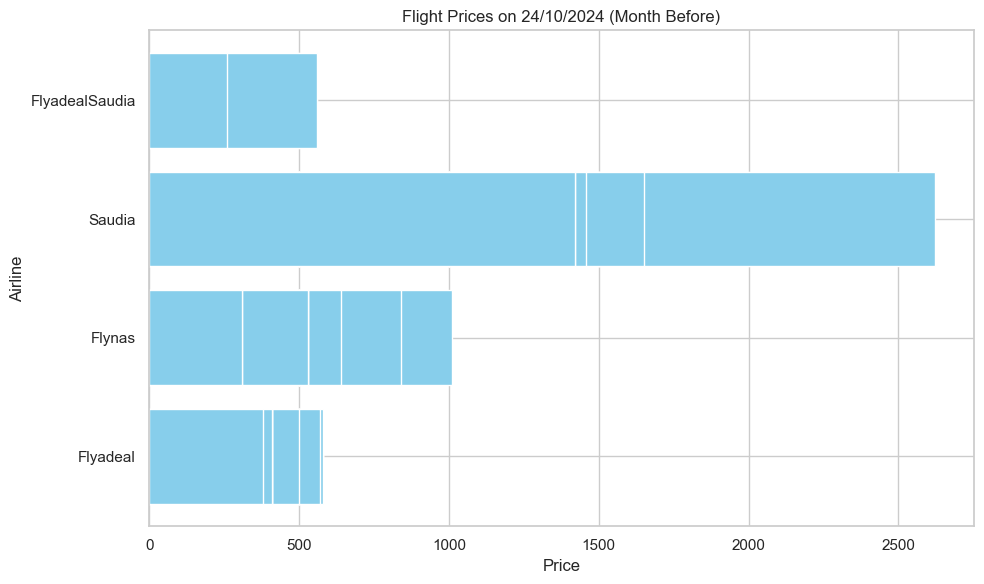

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: load your monthBefore dataset
# monthBefore = pd.read_csv('path_to_your_dataset.csv')

# Filter for the specific date (24/10/2024)
target_date = pd.to_datetime('2024-10-24')
filtered_data = monthBefore[
    (monthBefore['Departure Date'] == target_date) & 
    (monthBefore['Number Of Stops'] == 0)  # Add condition for zero stops
]

# Check if there's any data for the given date
if filtered_data.empty:
    print("No data available for the specified date.")
else:
    # Plotting the prices
    plt.figure(figsize=(10, 6))
    plt.barh(filtered_data['Airline'], filtered_data['Price'], color='skyblue')
    plt.title('Flight Prices on 24/10/2024 (Month Before)')
    plt.xlabel('Price')
    plt.ylabel('Airline')
    plt.tight_layout()
    plt.show()



In [136]:
print(filtered_data['Airline'].unique())


['Flyadeal' 'Flynas' 'Saudia' 'FlyadealSaudia']


##### It looks like "FlyadealSaudia" is an unintended combination of two airline names

##### Since we are not sure it is under what airline we will replace any instances of "FlyadealSaudia" with separate entries.

In [138]:
# Replace the combined airline name with separate entries
filtered_data['Airline'] = filtered_data['Airline'].replace('FlyadealSaudia', 'Flyadeal', regex=True)

# You may also want to ensure that if a flight is listed under 'FlyadealSaudia', it has a separate entry for 'Saudia'.
# Assuming that you want to keep separate entries for each airline.
# Create a new DataFrame that splits combined entries into individual ones
combined_airlines = filtered_data[filtered_data['Airline'] == 'FlyadealSaudia']

# Create new entries for 'Saudia' from the combined entries
for _, row in combined_airlines.iterrows():
    new_row = row.copy()
    new_row['Airline'] = 'Saudia'  # Set the airline to 'Saudia'
    filtered_data = filtered_data.append(new_row, ignore_index=True)

# Now, drop the original combined entry
filtered_data = filtered_data[filtered_data['Airline'] != 'FlyadealSaudia']

# Check unique values again
print(filtered_data['Airline'].unique())

['Flyadeal' 'Flynas' 'Saudia']


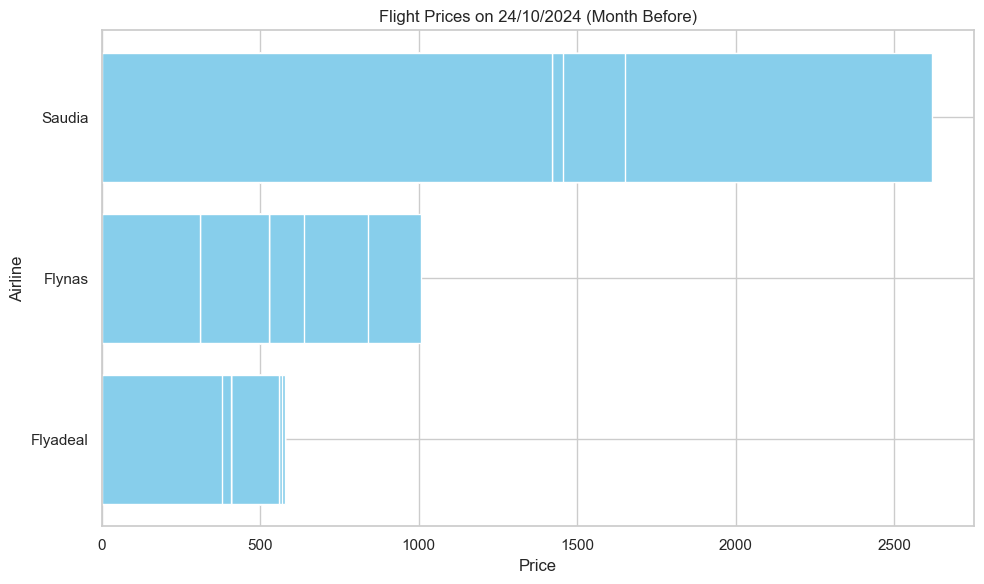

In [139]:
# Plotting the prices
plt.figure(figsize=(10, 6))
plt.barh(filtered_data['Airline'], filtered_data['Price'], color='skyblue')
plt.title('Flight Prices on 24/10/2024 (Month Before)')
plt.xlabel('Price')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

In [140]:
min_price = filtered_data['Price'].min()
max_price = filtered_data['Price'].max()
    
# Calculate the range
price_range = max_price - min_price
    
# Print the results
print(f"Minimum Price: {min_price}")
print(f"Maximum Price: {max_price}")
print(f"Price Range: {price_range}")

Minimum Price: 179.0
Maximum Price: 2621.0
Price Range: 2442.0


### Week before a flight

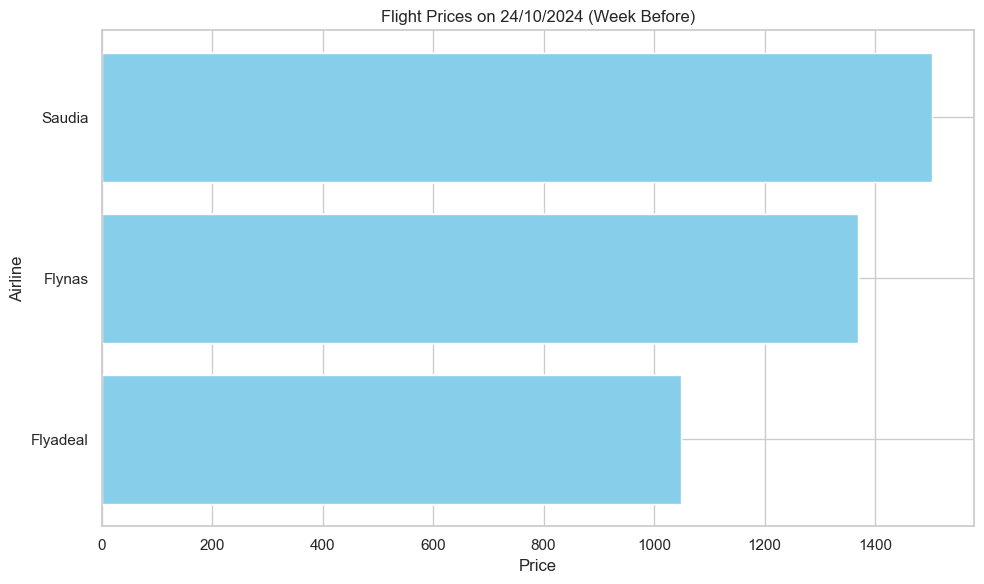

In [131]:

filtered_data2 = weekBefore[
    (weekBefore['Departure Date'] == target_date) & 
    (weekBefore['Number Of Stops'] == 0)  # Add condition for zero stops
]

# Check if there's any data for the given date
if filtered_data2.empty:
    print("No data available for the specified date.")
else:
    # Plotting the prices
    plt.figure(figsize=(10, 6))
    plt.barh(filtered_data2['Airline'], filtered_data2['Price'], color='skyblue')
    plt.title('Flight Prices on 24/10/2024 (Week Before)')
    plt.xlabel('Price')
    plt.ylabel('Airline')
    plt.tight_layout()
    plt.show()


In [132]:
min_price2 = filtered_data2['Price'].min()
max_price2 = filtered_data2['Price'].max()
    
# Calculate the range
price_range2 = max_price2 - min_price2
    
# Print the results
print(f"Minimum Price: {min_price2}")
print(f"Maximum Price: {max_price2}")
print(f"Price Range: {price_range2}")

Minimum Price: 319.0
Maximum Price: 1504.0
Price Range: 1185.0


### Day before a flight

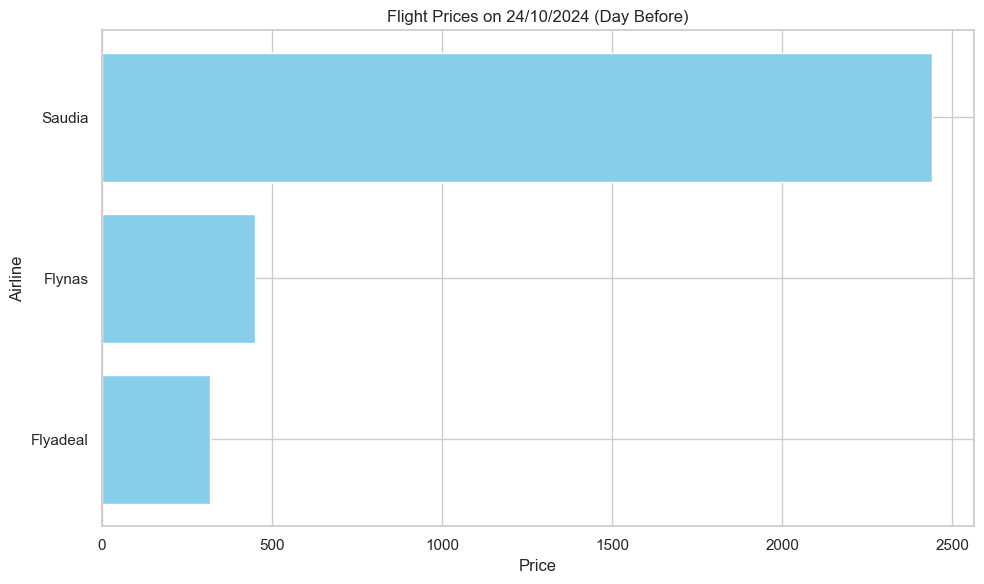

In [151]:
filtered_data3 = dayBefore[
    (dayBefore['Departure Date'] == target_date) & 
    (dayBefore['Number Of Stops'] == 0)  
]

# Check if there's any data for the given date
if filtered_data3.empty:
    print("No data available for the specified date.")
else:
    # Plotting the prices
    plt.figure(figsize=(10, 6))
    plt.barh(filtered_data3['Airline'], filtered_data3['Price'], color='skyblue')
    plt.title('Flight Prices on 24/10/2024 (Day Before)')
    plt.xlabel('Price')
    plt.ylabel('Airline')
    plt.tight_layout()
    plt.show()

In [134]:
min_price3 = filtered_data3['Price'].min()
max_price3 = filtered_data3['Price'].max()
    
# Calculate the range
price_range3 = max_price3 - min_price3
    
# Print the results
print(f"Minimum Price: {min_price3}")
print(f"Maximum Price: {max_price3}")
print(f"Price Range: {price_range3}")

Minimum Price: 219.0
Maximum Price: 2442.0
Price Range: 2223.0


### Price Analysis

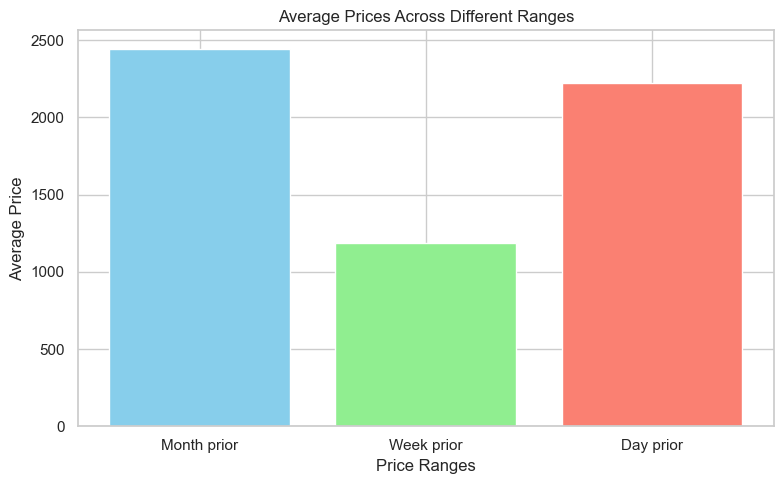

In [149]:
import matplotlib.pyplot as plt

# Example data for price ranges
price_ranges = ['Month prior', 'Week prior', 'Day prior']
price_values = [price_range.mean(), price_range2.mean(), price_range3.mean()]  

plt.figure(figsize=(8, 5))
plt.bar(price_ranges, price_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Average Prices Across Different Ranges')
plt.xlabel('Price Ranges')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

##### The price range is highest when booking a month in advance (2442.0), indicating greater variability in ticket prices. This trend may be attributed to airlines offering a mix of lower and higher-priced tickets as they anticipate demand over time.

##### As the departure date approaches, the price range decreases significantly when booking a week before (1185.0), but remains notable for last-minute bookings a day prior (2223.0). This fluctuation suggests that airlines adjust their pricing strategies based on remaining seat availability and expected demand as the flight date nears.

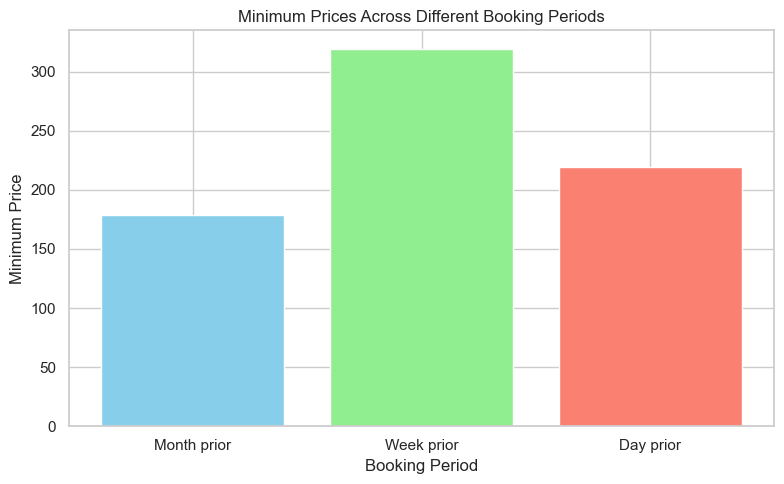

In [150]:
price_ranges = ['Month prior', 'Week prior', 'Day prior']
price_values = [min_price, min_price2, min_price3]  

plt.figure(figsize=(8, 5))
plt.bar(price_ranges, price_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Minimum Prices Across Different Booking Periods')
plt.xlabel('Booking Period')
plt.ylabel('Minimum Price')
plt.tight_layout()
plt.show()


##### The plot illustrates the minimum prices for flights across different booking periods: 179.0 for a month prior, 319.0 for a week prior, and 219.0 for a day prior. Booking a month in advance offers the lowest minimum price, reflecting airlines' strategies to attract early travelers. The increase in minimum price to 319.0 one week before departure indicates heightened demand as the travel date nears. Interestingly, the minimum price drops to 219.0 for last-minute bookings, suggesting that airlines may adjust prices to fill remaining seats. This dynamic pricing approach highlights how airlines balance demand and revenue management, offering varying fare options based on booking timing

### Flight Counts

Month prior flights on 2024-10-24 00:00:00: 156
Week prior flights on 2024-10-24 00:00:00: 45
Day prior flights on 2024-10-24 00:00:00: 60
Difference between num of flights a month before and a week: 111
Difference between num of flights a week before and a day: -15
Difference between num of flights a month before and a day: 96


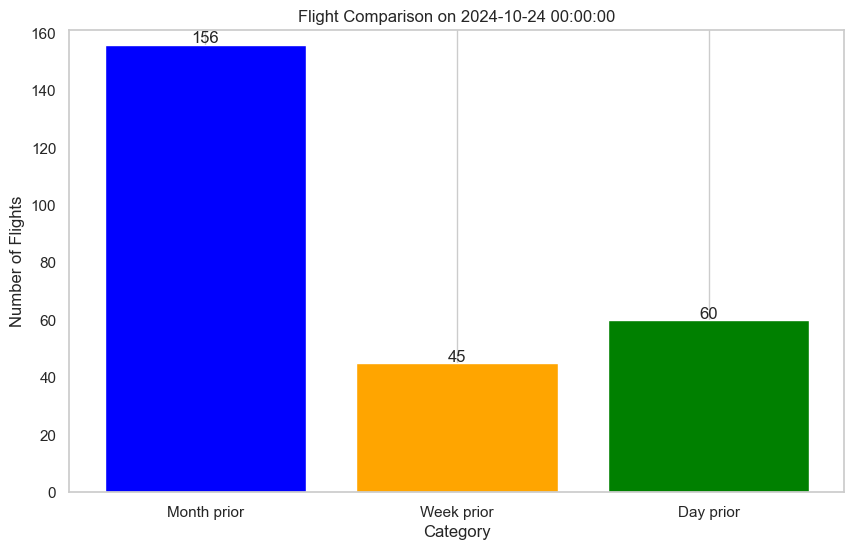

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# Count flights for that day
month_flights_count = filtered_data.shape[0]
week_flights_count = filtered_data2.shape[0]
day_flights_count = filtered_data3.shape[0]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Category': ['Month prior', 'Week prior', 'Day prior'],
    'Flights Count': [month_flights_count, week_flights_count, day_flights_count]
})

# Calculate the difference
differenceMonthAndWeek = month_flights_count - week_flights_count
differenceWeekAndDay = week_flights_count - day_flights_count
differenceMonthAndDay = month_flights_count - day_flights_count

# Display the comparison and difference
print(f"Month prior flights on {target_date}: {month_flights_count}")
print(f"Week prior flights on {target_date}: {week_flights_count}")
print(f"Day prior flights on {target_date}: {day_flights_count}")
print(f"Difference between num of flights a month before and a week: {differenceMonthAndWeek}")
print(f"Difference between num of flights a week before and a day: {differenceWeekAndDay}")
print(f"Difference between num of flights a month before and a day: {differenceMonthAndDay}")

# Plot the comparison
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.bar(comparison_df['Category'], comparison_df['Flights Count'], color=['blue', 'orange', 'green'])
plt.title(f"Flight Comparison on {target_date}")
plt.ylabel('Number of Flights')
plt.xlabel('Category')

# Annotate the count on the plot
for i, count in enumerate(comparison_df['Flights Count']):
    plt.text(i, count + 0.5, str(count), ha='center')

# Show plot
plt.ylim(0, max(comparison_df['Flights Count']) + 5)  # Adjust y-limit for better visualization
plt.grid(axis='y')  # Add gridlines for better readability
plt.show()


##### Month vs. Week: The number of flights decreased by 111 from a month before to a week before the target date. This significant drop could indicate a reduction in available flights as the departure date approaches, possibly due to airlines optimizing their schedules closer to the travel date or cancellations.
##### Week vs. Day: The count increased by 15 from a week before to the day before. This could suggest that airlines added more flights as the departure date approached to accommodate last-minute travelers.
##### Month vs. Day: There is a decrease of 96 flights from a month before to a day before. This might reflect a trend where many travelers booked flights well in advance, leading to a higher number a month prior, while fewer flights were available as the date approached.